In [2]:
!pip install pytorch-lightning
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import torch

import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping



from google.colab import drive
drive.mount('/content/drive')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import os

# Replace 'path/to/your/file.csv' with the actual path to your file in Google Drive
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AAI-530/iot_telemetry_data.csv', engine='python')
print(data.head())
df = data


df = df.sort_values(by="ts")  # Ensure time ordering
df["ts"] = pd.to_datetime(df["ts"], unit='s')  # Convert timestamp

# Select relevant features for prediction
features = ["humidity", "co", "lpg", "smoke", "temp"]

# Normalize the data
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Convert to numpy array
data = df[features].values

# Define dataset class for PyTorch Lightning
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length=10):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length, :-1]  # Input features
        y = self.data[idx + self.seq_length, -1]  # Temperature target

        # Convert to PyTorch tensors and stack x
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return x, y

# Split dataset
seq_length = 10
train_size = int(0.8 * len(data))
train_dataset = TimeSeriesDataset(data[:train_size], seq_length)
test_dataset = TimeSeriesDataset(data[train_size:], seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Transformer Model
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length=10):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length, :-1]  # Input features
        y = self.data[idx + self.seq_length, -1]  # Temperature target

        # Convert to PyTorch tensors and stack x
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return x, y  # Return x as a single tensor, and y as a tensor

# Split dataset
seq_length = 10
train_size = int(0.8 * len(data))
train_dataset = TimeSeriesDataset(data[:train_size], seq_length)
test_dataset = TimeSeriesDataset(data[train_size:], seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Transformer Model
class TransformerTimeSeries(pl.LightningModule):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, lr=1e-3):
        super().__init__()
        self.lr = lr
        self.encoder = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=nhead, num_encoder_layers=num_layers, num_decoder_layers=num_layers
        )
        self.decoder = nn.Linear(d_model, 1)
        self.loss_fn = nn.MSELoss()

    def forward(self, src):
        # Ensure src is a tensor with the correct shape and data type
        # Convert src to a tensor if it is a list

        src = src.view(src.size(0), src.size(1), -1).float()  # Reshape and convert to float


        src = self.encoder(src)
        output = self.transformer(src, src)
        return self.decoder(output[:, -1, :])  # Predict next time step


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        loss = self.loss_fn(y_pred, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        loss = self.loss_fn(y_pred, y)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Instantiate the model
model = TransformerTimeSeries(input_dim=len(features) - 1)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
             ts             device        co   humidity  light       lpg  \
0  1.594512e+09  b8:27:eb:bf:9d:51  0.004956  51.000000  False  0.007651   
1  1.594512e+09  00:0f:00:70:91:0a  0.002840  76.000000  False  0.005114   
2  1.594512e+09  b8:27:eb:bf:9d:51  0.004976  50.900000  False  0.007673   
3  1.594512e+09  1c:bf:ce:15:ec:4d  0.004403  76.800003   True  0.007023   
4  1.594512e+09  b8:27:eb:bf:9d:51  0.004967  50.900000  False  0.007664   

   motion     smoke       temp  
0   False  0.020411  22.700000  
1   False  0.013275  19.700001  
2   False  0.020475  22.600000  
3   False  0.018628  27.000000  
4   False  0.020448  22.600000  


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import os

# Install necessary libraries
!pip install pytorch-lightning

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AAI-530/iot_telemetry_data.csv', engine='python')

# Preprocess the data
df = data.copy()
df = df.sort_values(by="ts")
df["ts"] = pd.to_datetime(df["ts"], unit='s')
features = ["humidity", "co", "lpg", "smoke", "temp"]
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
data = df[features].values

# Define the dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length=10):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length, :-1]  # Input features only
        y = self.data[idx + self.seq_length, -1]  # Target (temperature)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Split the data
seq_length = 10
train_size = int(0.8 * len(data))
train_dataset = TimeSeriesDataset(data[:train_size], seq_length)
test_dataset = TimeSeriesDataset(data[train_size:], seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model
class TransformerTimeSeries(pl.LightningModule):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()  # Save hyperparameters for easier loading
        self.encoder = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead,
                                           num_encoder_layers=num_layers,
                                           num_decoder_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        # Reshape and ensure float type within forward
        x = x.view(x.size(0), x.size(1), -1).float()
        x = self.encoder(x)
        output = self.transformer(x, x)  # Pass x as both encoder and decoder input
        return self.decoder(output[:, -1, :])  # Predict next time step

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        loss = self.loss_fn(y_pred, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        loss = self.loss_fn(y_pred, y)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, _ = batch  # Extract input features, ignore target
        return self(x)  # Directly call forward with input features

# Train the model
model = TransformerTimeSeries(input_dim=len(features) - 1)
trainer = pl.Trainer(max_epochs=1, accelerator="gpu" if torch.cuda.is_available() else "cpu",
                     devices=1 if torch.cuda.is_available() else 0)
trainer.fit(model, train_loader)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | encoder     | Linear      | 320    | train
1 | transformer | T

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

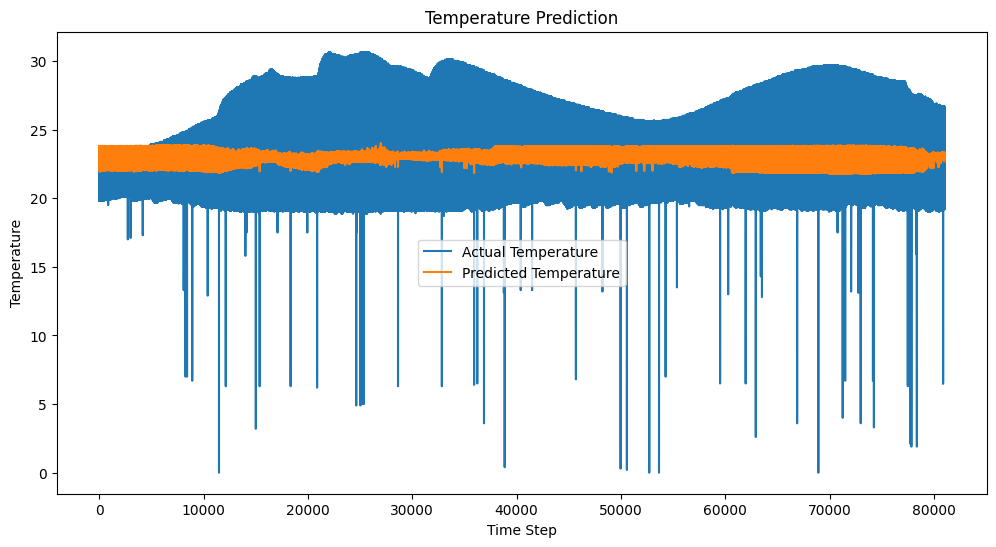

In [4]:

predictions = trainer.predict(model, test_loader)
predictions = torch.cat(predictions).cpu().numpy()  # Concatenate and move to CPU

# Create a new scaler for the target variable (temperature) only
temp_scaler = MinMaxScaler()
temp_scaler.min_, temp_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1] # Extract min and scale for temperature

# Inverse transform to get actual temperature values
predicted_temps = temp_scaler.inverse_transform(predictions.reshape(-1, 1))  # Use temp_scaler here
predicted_temps = predicted_temps.flatten() # Flatten to 1D

# Get actual temperatures using temp_scaler
actual_temps = temp_scaler.inverse_transform(data[train_size + seq_length:][:, -1].reshape(-1, 1))
actual_temps = actual_temps.flatten() # Flatten to 1D

plt.figure(figsize=(12, 6))
plt.plot(actual_temps, label='Actual Temperature')
plt.plot(predicted_temps, label='Predicted Temperature')
plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.title('Temperature Prediction')
plt.legend()
plt.show()

[22.971527 23.776297 22.9721   22.9721   23.783812 22.06364  22.971992
 22.972202 22.971317 23.773079 22.972445 22.053585 22.972532 22.032555
 23.783812 22.97188  23.781038 22.972208 22.035385 22.971813 22.026667
 22.971167 23.786095 22.971554 22.97087  23.781038 22.968338 22.07035
 22.96686  22.036585 23.775246 22.9683   23.00197  23.800503 22.053797
 23.00221  22.050879 23.800503 23.00197  22.065851 23.000568 23.805832
 22.050879 23.001244 22.065851 23.797203 23.000698 22.037064 23.00014
 23.000807 22.043863 23.803831 23.003132 22.043863 23.002277 22.043863
 23.001719 23.791483 23.000887 23.809126 22.06764  23.001606 22.043863
 23.003231 23.797564 22.9875   22.986275 21.911963 22.017918 22.986164
 22.985514 22.057312 22.983965 23.791279 22.983969 22.983324 22.065851
 23.7971   22.982292 22.03233  22.982723 23.797564 22.980581 23.802874
 22.980171 22.057312 22.979715 22.057312 22.979338 22.017918 23.785255
 22.978645 22.978136 23.802874 22.050413 22.977749 22.971708 23.795609
 22.9717

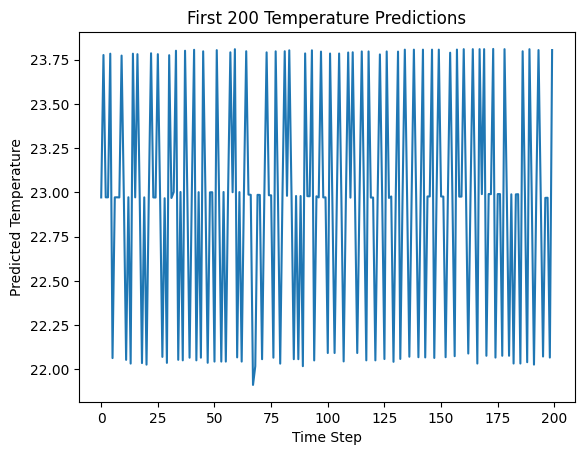

In [5]:

first_200_predictions = predicted_temps[:200]  # Adjust if predictions has a different shape

# Print the predictions
print(first_200_predictions)

# You can also plot them:
plt.plot(first_200_predictions)
plt.xlabel('Time Step')
plt.ylabel('Predicted Temperature')
plt.title('First 200 Temperature Predictions')
plt.show()

Anomaly indices: [70364 70371 70378 70625 70630 70635 70730 70735 70740 70746 70749 70796
 70801 70804 70809 70815 70834 70837 70848 70867 70876 70886 70891 70895
 70902 70911 70915 70930 70935 70939 70942 70990 70994 70998 71001 71008
 71017 71040 71044 71047 71058 71062 71066 71093 71098 71655 71666 71670
 71674 71677 71715 71719 71732 71809 71818 71825 72001 72011 72021 72024
 72036 72045 72048 72051 72059 72154 72288 72292 72297 72300 72303 72311
 72840 73072 73081 73100 73103 73107 73110 73121 73127 73136 73141 73146
 73149 73159 73170 73175 73178 73189 73192 73196 73213 73379 73383 73397
 73799 73802 73809 73818]
Anomalous temperature values: [23.811785 21.799986 23.817545 23.809217 21.791586 21.793852 23.811949
 21.79928  23.809269 21.801714 21.800722 23.816345 21.801617 21.79947
 21.796318 21.792068 21.794931 21.791458 21.788311 23.817936 21.786938
 21.79937  21.796972 21.799122 23.807472 21.800802 23.811834 23.811544
 23.81114  21.800802 21.800802 21.792171 23.81567  23.81584 

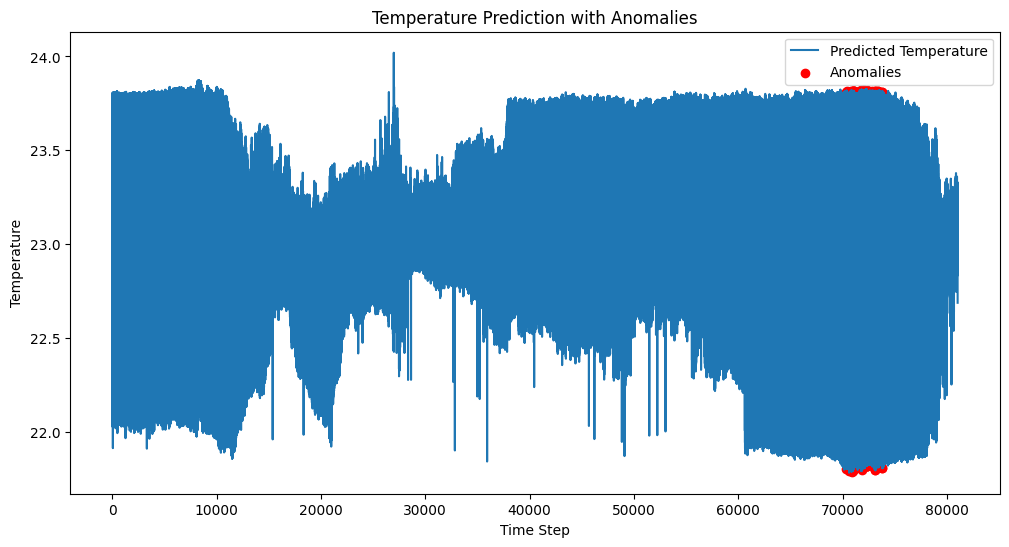

In [6]:


import numpy as np



threshold = 2  # Example threshold. Adjust this value based on your data.

# Calculate the absolute difference between consecutive predictions
differences = np.abs(np.diff(predicted_temps))

# Find indices where the difference exceeds the threshold
anomaly_indices = np.where(differences > threshold)[0]

# Print the indices of the anomalies
print("Anomaly indices:", anomaly_indices)

# You can also print the actual values that are considered anomalies:
print("Anomalous temperature values:", predicted_temps[anomaly_indices + 1]) # +1 because diff is one step behind

# Plot the data with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(predicted_temps, label='Predicted Temperature')
plt.scatter(anomaly_indices + 1, predicted_temps[anomaly_indices + 1], color='red', label='Anomalies')
plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.title('Temperature Prediction with Anomalies')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from google.colab import drive
import os

# Install necessary libraries
!pip install pytorch-lightning

# Mount Google Drive
drive.mount('/content/drive')

# Load and preprocess data
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AAI-530/iot_telemetry_data.csv', engine='python')
df = data.copy().sort_values(by="ts")
df["ts"] = pd.to_datetime(df["ts"], unit='s')
features = ["humidity", "co", "lpg", "smoke", "temp"]

# Split data first to prevent leakage
train_size = int(0.8 * len(df))
train_df, test_df = df.iloc[:train_size], df.iloc[train_size:]

# Scale data properly
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])

train_data = train_df[features].values
test_data = test_df[features].values

# Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length=10):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length, :-1]  # Input features
        y = self.data[idx+self.seq_length, -1]       # Target temperature
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Create datasets and loaders
seq_length = 10
train_dataset = TimeSeriesDataset(train_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Improved Transformer model
class TransformerTimeSeries(pl.LightningModule):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2,
                 lr=1e-3, max_seq_length=10):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Embedding(max_seq_length, d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead),
            num_layers=num_layers
        )
        self.decoder = nn.Linear(d_model, 1)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        x = self.encoder(x)
        x = x.permute(1, 0, 2)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(1)
        positions = positions.expand(seq_len, batch_size)
        x = x + self.pos_encoder(positions)
        encoded = self.transformer_encoder(x)
        encoded = encoded.permute(1, 0, 2)
        return self.decoder(encoded[:, -1, :]).squeeze()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
      x, _ = batch
      return self(x)


# Initialize and train the model
model = TransformerTimeSeries(
    input_dim=len(features)-1,  # 4 input features
    max_seq_length=seq_length
)

trainer = pl.Trainer(
    max_epochs=1,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else "auto"
)
trainer.fit(model, train_loader, train_loader) # Use train_loader for both train and val for this example


predictions = trainer.predict(model, test_loader)
predictions = torch.cat(predictions).cpu().numpy()

temp_scaler = MinMaxScaler()
temp_scaler.min_, temp_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
predicted_temps = temp_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

actual_temps = temp_scaler.inverse_transform(test_data[seq_length:][:, -1].reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 6))
plt.plot(actual_temps, label='Actual Temperature')
plt.plot(predicted_temps, label='Predicted Temperature')
plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.title('Temperature Prediction')
plt.legend()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-7-b787e5d2e2e8>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[features] = scaler.fit_transform(train_df[features])
<ipython-input-7-b787e5d2e2e8>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[features] = scaler.transform(test_df[features])
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [8]:

first_100_predictions = predicted_temps[:100]
first_100_predictions

array([22.293118, 24.450155, 24.427446, 22.513401, 24.565533, 24.060278,
       22.521797, 22.42241 , 22.831604, 24.574274, 24.41212 , 22.37584 ,
       22.293098, 22.36482 , 23.887403, 24.65965 , 24.495653, 24.536062,
       22.408998, 22.348816, 22.30487 , 22.591833, 24.50766 , 24.396597,
       22.548279, 24.46299 , 24.6142  , 22.394905, 22.266779, 22.403728,
       23.908346, 24.635807, 22.63017 , 24.532915, 23.833012, 22.480894,
       22.34843 , 23.786148, 24.14297 , 22.385937, 22.279655, 24.49288 ,
       23.899473, 22.469463, 22.361752, 23.76237 , 24.302055, 22.373737,
       22.288471, 22.507849, 22.250717, 23.722952, 24.356865, 22.36725 ,
       22.298613, 22.401854, 22.536604, 24.534111, 24.339602, 24.422012,
       23.988684, 22.521666, 22.398602, 22.262037, 24.48111 , 24.216206,
       22.562904, 22.188557, 23.868958, 22.504955, 22.488304, 22.351805,
       22.629625, 24.438696, 24.583376, 22.61227 , 22.258747, 23.773306,
       24.41422 , 22.376408, 22.289907, 24.528786, 